<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/Transformer_%EC%8B%A4%EC%8A%B5%EA%B3%BC%EC%A0%9C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install transformers

In [57]:
!pip install sentencepiece

In [107]:
# -*- coding: utf-8 -*-
"""7-13.transformer(chat).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1pnSh26gOExNccGZRzN7MkS1i0DPrElt3
"""

# Commented out IPython magic to ensure Python compatibility.
# Transformer ChatBot : 채팅 모듈
# 참고 : https://github.com/suyash/transformer
#
# 2020.06.07 : 조성현 (blog.naver.com/chunjein)
# ---------------------------------------------
import tensorflow.keras.backend as K
import pickle
import numpy as np
import re
import pickle
from sklearn.datasets import fetch_20newsgroups
import sentencepiece as spm
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%cd '/content/drive/MyDrive/머신러닝/Transformer'
from transformer import Transformer

/content/drive/MyDrive/머신러닝/Transformer


In [108]:
# news data를 읽어온다. subject 분석용.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('footers', 'quotes'))
# heard quotes, footer 만 있다 body 부분은 따로 없다.

In [109]:
# 첫 번째 news를 조회해 본다.
news = newsData['data']
topic = newsData['target']
topic_name = newsData['target_names']
n_topic = len(set(topic))
n=0
print(len(news))
print(news[n])
print('topic = ', topic[n], topic_name[topic[n]])

11314
From: ab4z@Virginia.EDU ("Andi Beyer")
Subject: Re: Israeli Terrorism
Organization: University of Virginia
Lines: 15
topic =  17 talk.politics.mideast


In [110]:
n_topic

20

In [62]:
# Subject만 추출한다.
subjects = []
for text in news:
    for sent in text.split('\n'):
        idx = sent.find('Subject:')
        if idx >= 0:       # found
            subjects.append(sent[(idx + 9):].replace('Re: ', '').lower())
           #subjects.append(re.sub("[^a-zA-Z]", " ", subject))
            break

In [63]:
subjects[0:5]

['israeli terrorism',
 'amusing atheists and agnostics',
 'rejoinder. questions to israelis',
 'clipper- business as usual?',
 'playoff pool rule revision']

In [64]:
len(subjects)

11314

In [65]:
# Sentencepice용 사전을 만들기 위해 corpusQA를 저장해 둔다.
data_file = "/content/drive/MyDrive/머신러닝/Transformer/news_subject.txt"
with open(data_file, 'w', encoding='utf-8') as f:
    for sent in subjects:
        f.write(sent + '\n')

In [128]:
# Google의 Sentencepiece를 이용해서 vocabulary를 생성한다.
# -----------------------------------------------------
templates= "--input={0:} \
            --pad_id=0 --pad_piece=<PAD>\
            --unk_id=1 --unk_piece=<UNK>\
            --bos_id=2 --bos_piece=<START>\
            --eos_id=3 --eos_piece=<END>\
            --model_prefix={1:} \
            --vocab_size={2:} \
            --character_coverage=0.9995 \
            --model_type=unigram"

VOCAB_SIZE = 5460
model_prefix = "/content/drive/MyDrive/머신러닝/Transformer/news_subject"
params = templates.format(data_file, model_prefix, VOCAB_SIZE)

spm.SentencePieceTrainer.Train(params)
sp = spm.SentencePieceProcessor()
sp.Load(model_prefix + '.model')

with open(model_prefix + '.vocab', encoding='utf-8') as f:
    vocab = [doc.strip().split('\t') for doc in f]

word2idx = {k:v for v, [k, _] in enumerate(vocab)}
idx2word = {v:k for v, [k, _] in enumerate(vocab)}

In [129]:
# string으로 조회
sentence = subjects[1]
enc = sp.encode_as_pieces(sentence)
dec = sp.decode_pieces(enc)

In [130]:
# word index로 조회
# idx = sp.encode_as_ids(sentence)
# dec = sp.decode_ids(idx)
print('\n    문장:', sentence)
print('Subwords:', enc)
print('    복원:', dec)


    문장: amusing atheists and agnostics
Subwords: ['▁am', 'using', '▁atheists', '▁and', '▁agnostic', 's']
    복원: amusing atheists and agnostics


In [131]:
# word index로 변환한다.
subject_idx = [sp.encode_as_ids(s) for s in subjects]

평균 = 7.932384656178186
최소 = 1
최대 = 62
중앙값 = 7.0


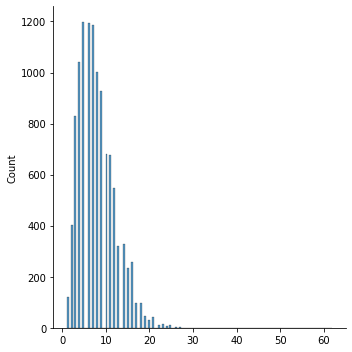

In [132]:
# subject을 길이 분포를 확인한다.
n_len = [len(sub) for sub in subject_idx]

print('평균 =', np.mean(n_len))
print('최소 =', np.min(n_len))
print('최대 =', np.max(n_len))
print('중앙값 =', np.median(n_len))

sns.displot(n_len)
plt.show()

In [133]:
# 문장 길이를 맞추고, 학습 데이터를 생성한다.
x_data = pad_sequences(subject_idx, maxlen=15, padding='post', truncating='post')
y_data = topic

# 학습 데이터와 시험데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9051, 15), (9051, 1), (2263, 15), (2263, 1))

In [134]:
# LSTM 모델을 생성한다.
EMB_SIZE = 32
VOCAB_SIZE = len(word2idx) + 1
x_input = Input(batch_shape = (None, x_train.shape[1]))
x_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
x_embed = Dropout(0.5)(x_embed)
x_lstm = LSTM(64, dropout=0.5)(x_embed)
y_output = Dense(n_topic, activation = 'softmax')(x_lstm)

model = Model(x_input, y_output)     # 학습, 예측용 모델
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.005))
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 15)]              0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 15, 32)            174752    
_________________________________________________________________
dropout_54 (Dropout)         (None, 15, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_54 (Dense)             (None, 20)                1300      
Total params: 200,884
Trainable params: 200,884
Non-trainable params: 0
_________________________________________________________________


In [135]:
# 모델을 학습한다.
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 512, epochs = 50)

Epoch 1/50
18/18 [==============================] - 2s 26ms/step - loss: 2.9629 - val_loss: 2.8193
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 2.6689 - val_loss: 2.4800
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 2.3052 - val_loss: 2.0752
Epoch 4/50
18/18 [==============================] - 0s 6ms/step - loss: 1.9117 - val_loss: 1.6656
Epoch 5/50
18/18 [==============================] - 0s 6ms/step - loss: 1.6034 - val_loss: 1.4279
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 1.3647 - val_loss: 1.1865
Epoch 7/50
18/18 [==============================] - 0s 6ms/step - loss: 1.1870 - val_loss: 1.0600
Epoch 8/50
18/18 [==============================] - 0s 7ms/step - loss: 1.0517 - val_loss: 0.9766
Epoch 9/50
18/18 [==============================] - 0s 7ms/step - loss: 0.9566 - val_loss: 0.9138
Epoch 10/50
18/18 [==============================] - 0s 6ms/step - loss: 0.9037 - val_loss: 0.8902
Epoch 11/50
18/18 

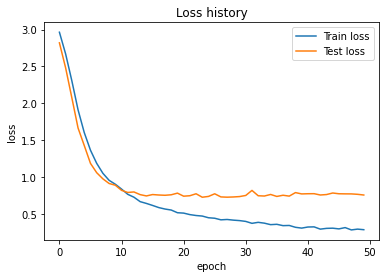

In [136]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [137]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 83.92 %


In [138]:
!pip install import_ipynb

In [139]:
import import_ipynb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [140]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [141]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [142]:
vocab_size = len(word2idx) +1  # Only consider the top 20k words
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 15

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(20, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizers.Adam(learning_rate=0.005), "sparse_categorical_crossentropy", metrics=["accuracy"])

In [145]:
hist = model.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test)
)

Epoch 1/10
283/283 [==============================] - 2s 6ms/step - loss: 0.5836 - accuracy: 0.8343 - val_loss: 0.9571 - val_accuracy: 0.7817
Epoch 2/10
283/283 [==============================] - 2s 6ms/step - loss: 0.3776 - accuracy: 0.8925 - val_loss: 0.9074 - val_accuracy: 0.8065
Epoch 3/10
283/283 [==============================] - 2s 6ms/step - loss: 0.2776 - accuracy: 0.9209 - val_loss: 1.1143 - val_accuracy: 0.8188
Epoch 4/10
283/283 [==============================] - 2s 6ms/step - loss: 0.2028 - accuracy: 0.9429 - val_loss: 1.1908 - val_accuracy: 0.8153
Epoch 5/10
283/283 [==============================] - 2s 6ms/step - loss: 0.1889 - accuracy: 0.9425 - val_loss: 1.3635 - val_accuracy: 0.8135
Epoch 6/10
283/283 [==============================] - 2s 6ms/step - loss: 0.1563 - accuracy: 0.9545 - val_loss: 1.5354 - val_accuracy: 0.8135
Epoch 7/10
283/283 [==============================] - 2s 6ms/step - loss: 0.1376 - accuracy: 0.9580 - val_loss: 1.6501 - val_accuracy: 0.8148
Epoch 

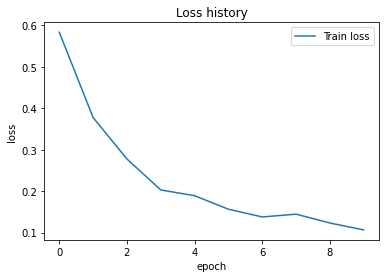

In [146]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [148]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 81.26 %
